<a href="https://colab.research.google.com/github/ankitanigam26/Python.Ankita/blob/main/Grape_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

In [ ]:
train_path = "/content/drive/MyDrive/n_dir/leaf disease classification/GRAPE Leaf/Grape"
test_path = "/content/drive/MyDrive/n_dir/leaf disease classification/GRAPE Leaf/test set grape"


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


Found 3225 images belonging to 4 classes.
Found 805 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
resnet_model = Sequential()
pretrained_model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

for layer in pretrained_model.layers[-10:]:
    layer.trainable = True

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(4, activation='softmax'))


optimizer = Adam(learning_rate=1e-4)
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

In [ ]:
history = resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/20
101/101 [==============================] - 2235s 22s/step - loss: 0.3248 - accuracy: 0.8896 - val_loss: 2.6930 - val_accuracy: 0.2646 - lr: 1.0000e-04
Epoch 2/20
101/101 [==============================] - 77s 764ms/step - loss: 0.0659 - accuracy: 0.9789 - val_loss: 4.7295 - val_accuracy: 0.2646 - lr: 1.0000e-04
Epoch 3/20
101/101 [==============================] - 77s 765ms/step - loss: 0.0416 - accuracy: 0.9870 - val_loss: 3.4945 - val_accuracy: 0.2646 - lr: 1.0000e-04
Epoch 4/20
101/101 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9932
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
101/101 [==============================] - 77s 764ms/step - loss: 0.0241 - accuracy: 0.9932 - val_loss: 4.3336 - val_accuracy: 0.3379 - lr: 1.0000e-04
Epoch 5/20
101/101 [==============================] - 78s 772ms/step - loss: 0.0228 - accuracy: 0.9935 - val_loss: 3.9937 - val_accuracy: 0.2596 - lr: 1.0000e-05
Epoch 6/20
101/101 [=========

In [ ]:
loss, accuracy = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 362ms/step - loss: 0.0031 - accuracy: 1.0000
Test Accuracy: 1.0


In [ ]:
predictions = resnet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report and confusion matrix
print("Classification Report:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(true_classes, predicted_classes))

1/1 [==============================] - 1s 1s/step
Classification Report:
                                             precision    recall  f1-score   support

                           Grape_Black_Rot       1.00      1.00      1.00         8
              Grape___Esca_(Black_Measles)       1.00      1.00      1.00         8
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00         8
                          Grape___healthy        1.00      1.00      1.00         8

                                  accuracy                           1.00        32
                                 macro avg       1.00      1.00      1.00        32
                              weighted avg       1.00      1.00      1.00        32

Confusion Matrix:
 [[8 0 0 0]
 [0 8 0 0]
 [0 0 8 0]
 [0 0 0 8]]


In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
# Extract data from the history object
EPOCHS = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

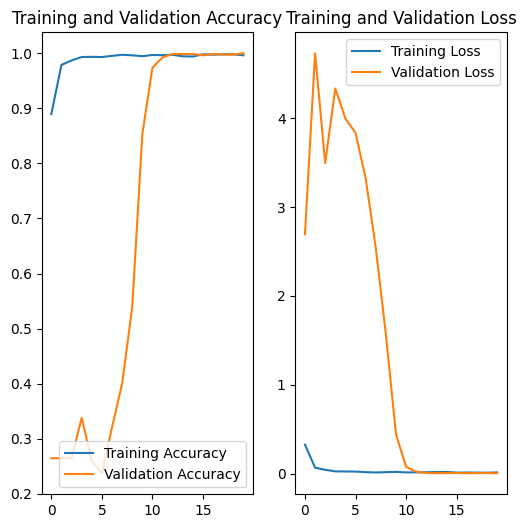

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

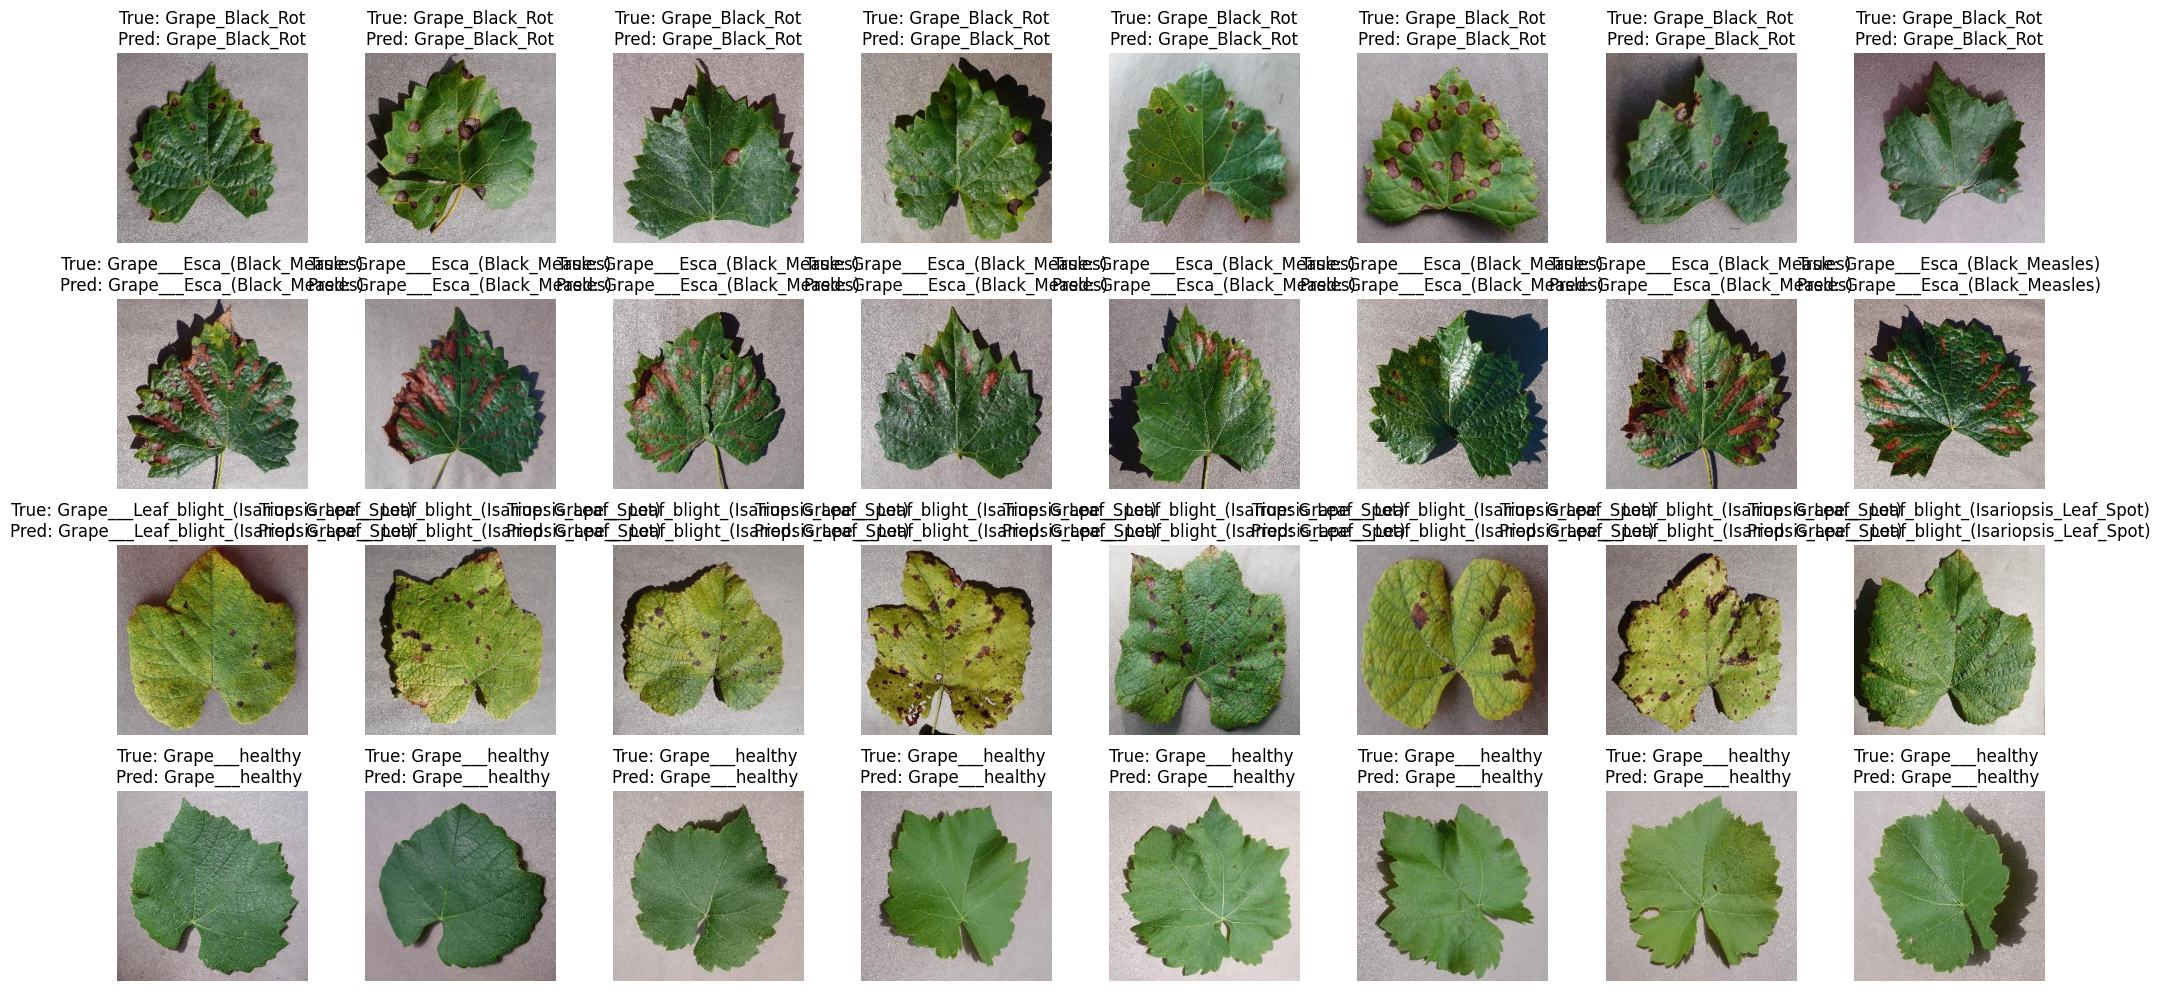

In [ ]:
from tensorflow.keras.preprocessing import image
correctly_classified_indexes = [i for i in range(len(true_classes)) if true_classes[i] == predicted_classes[i]]
num_images_to_display = 32

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

for idx, ax in zip(correctly_classified_indexes[:num_images_to_display], axes):  # Adjust the number of images to display as needed
    img = image.load_img(test_generator.filepaths[idx])
    ax.imshow(img)
    ax.set_title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Saved models/Grape.Resnet50.model.h5")


In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Saved models/Grape.Resnet50.model.h5"

In [ ]:
test_2_path = "/content/drive/MyDrive/n_dir/leaf disease classification/GRAPE Leaf/Grape_Test_google_images"

In [ ]:
from PIL import Image
def convert_images_to_jpg(directory):
    for filename in os.listdir(directory):
        if not filename.lower().endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            rgb_im = img.convert('RGB')
            new_filename = os.path.splitext(filename)[0] + '.jpg'
            rgb_im.save(os.path.join(directory, new_filename))
            os.remove(img_path)

convert_images_to_jpg(test_2_path)

In [ ]:
img_path

'/content/drive/MyDrive/n_dir/leaf disease classification/GRAPE Leaf/Grape_Test_google_images/Healthy.jpg'

In [ ]:
test_2_path

'/content/drive/MyDrive/n_dir/leaf disease classification/GRAPE Leaf/Grape_Test_google_images'

1/1 [==============================] - 0s 187ms/step


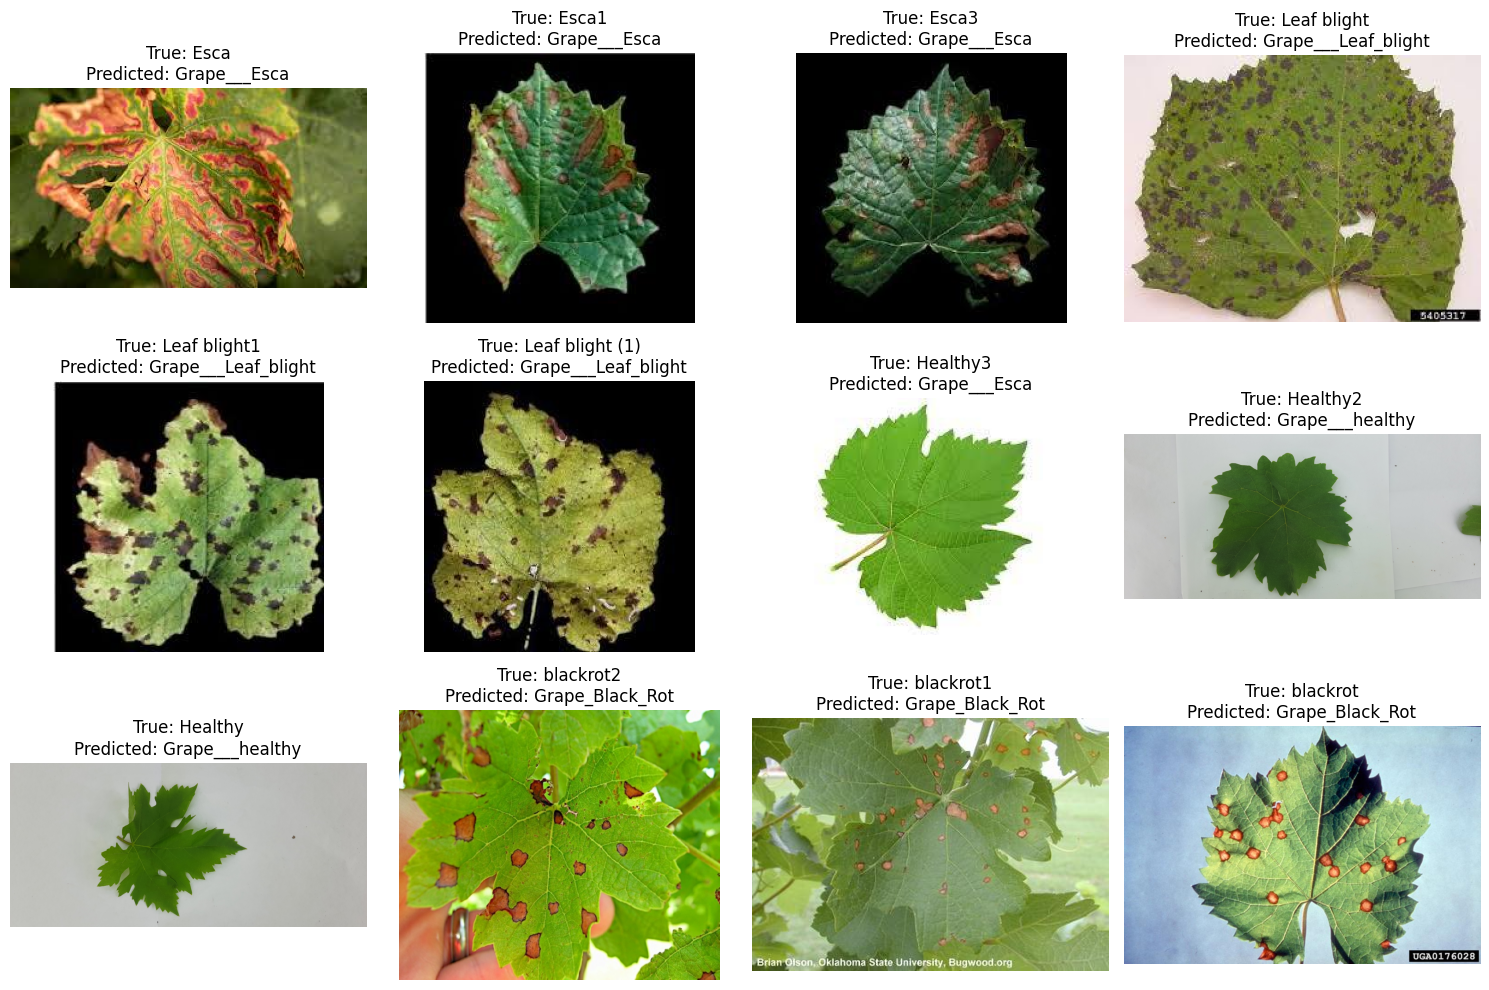

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model(model_path)

class_names = [
    "Grape_Black_Rot",
    "Grape___Esca",
    "Grape___Leaf_blight",
    "Grape___healthy"
]

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch size of 1
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

image_paths = [os.path.join(test_2_path, img) for img in os.listdir(test_2_path) if img.lower().endswith('.jpg')]

def get_true_class_name(filename):
    base = os.path.basename(filename)
    name = os.path.splitext(base)[0]
    return name.replace('_', ' ')


plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_paths):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_names[predicted_class]
    true_class_name = get_true_class_name(img_path)

    # Plot the image with its true and predicted class
    plt.subplot(3, 4, i+1)
    plt.imshow(Image.open(img_path))
    plt.title(f'True: {true_class_name}\nPredicted: {predicted_class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

